# Data Based Vehicle Energy Consumption Modeling
---
* In this project, we have a real data set at hand which consists of various features regarding driving profiles of electric delivery trucks. The goal of this project is to investigate this data, and better understand some characteristics of electric vehicles as well as their energy consumption.

* This is a data analysis project. The students will

> 1.  Perform data cleaning and preprocessing
> 2.  Perform clustering to catch some patterns in the data
> 3.  Use concepts from machine learning for a detailed investigation of the data
> 4.  Perform visualization to present the outcomes of their investigation

*   **Students**: Mert Kılıçaslan, Serhan Yorulmaz, Yunus Delipınar
*   **Supervisors**: Tuğçe Yüksel, Öznur Taştan, Mert Özçelik

## 0.1. Import Libraries

In [3]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.integrate import trapz
pd.options.mode.chained_assignment = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2. Understanding data

In [ ]:
# Shortcut of the 'ENS491 / F22' file must be added to My Drive
path_prefix = "/content/drive/MyDrive/ENS 491   F22/Data/Smith_Gen2 Vehicles Data/vehicle_109"
fname = "device_06D_2014-08-14" 

In [ ]:
mat = loadmat(join(path_prefix, fname))
mat = {k:v for k, v in mat.items() if k[0] != '_'}
df = pd.DataFrame({k: np.array(v).flatten() for k, v in mat.items()})

df.head()

,Act1_Iacm_CA,Act1_Iacm_CB,ms_nmot,Lowest_Cell_Voltage_SBS3,Lowest_Cell_Voltage_SBS2,Lowest_Cell_Voltage_SBS1,Lowest_Cell_Voltage_SBS6,Lowest_Cell_Voltage_SBS5,VS_DCMD,SOC_SYS,...,BMU_Mode_SYS,CT_Air_Con_Current_RD,ms_tmc1,Lowest_Cell_Temperature_SBS6,ms_ths5,vs_bcmd,GPS_Longitude,ms_ths1,ms_ths3,ms_ths2
0,NaN,NaN,NaN,3469.0,3467.0,NaN,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-122.320275,NaN,NaN,NaN
1,NaN,NaN,NaN,3469.0,3467.0,NaN,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-122.320274,NaN,NaN,NaN
2,NaN,NaN,NaN,3469.0,3467.0,NaN,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-122.320273,NaN,NaN,NaN
3,NaN,NaN,NaN,3469.0,3467.0,NaN,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-122.320273,NaN,NaN,NaN
4,NaN,NaN,NaN,3469.0,3467.0,NaN,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-122.320273,NaN,NaN,NaN


| Channel Name                 | Description                                  |
|------------------------------|----------------------------------------------|
| Timestamp                    | Time stamp                                   |
| BMU_Mode_SYS                 | Battery Management Mode                      |
| GPS_Speed                    | GPS Speed                                    |
| VS_DCMD                      | Accelerator pedal position                   |
| vs_bcmd                      | Brake pedal position                         |
| Battery_Current_SYS          | Battery System Current                       |
| Battery_Voltage_SYS          | Battery System Voltage                       |
| Lowest_Cell_Voltage_SBS1     | Battery Cell Voltage                         |
| Lowest_Cell_Voltage_SBS2     | Battery Cell Voltage                         |
| Lowest_Cell_Voltage_SBS3     | Battery Cell Voltage                         |
| Lowest_Cell_Voltage_SBS4     | Battery Cell Voltage                         |
| Highest_Cell_Voltage_SBS1    | Battery Cell Voltage                         |
| Highest_Cell_Voltage_SBS2    | Battery Cell Voltage                         |
| Highest_Cell_Voltage_SBS3    | Battery Cell Voltage                         |
| Highest_Cell_Voltage_SBS4    | Battery Cell Voltage                         |
| GPS_Latitude                 | GPS Latitude                                 |
| GPS_Longitude                | GPS Longitude                                |
| GPS_Altitude                 | GPS Altitude                                 |
| Lowest_Cell_Temperature_SBS1 | Battery Cell Temperature                     |
| Lowest_Cell_Temperature_SBS2 | Battery Cell Temperature                     |
| Lowest_Cell_Temperature_SBS3 | Battery Cell Temperature                     |
| Lowest_Cell_Temperature_SBS4 | Battery Cell Temperature                     |
| Highest_Cell_Temperature_SBS1| Battery Cell Temperature                     |
| Highest_Cell_Temperature_SBS2| Battery Cell Temperature                     |
| Highest_Cell_Temperature_SBS3| Battery Cell Temperature                     |
| Highest_Cell_Temperature_SBS4| Battery Cell Temperature                     |
| ms_tmf1                      | Motor temperature sensor 1                   |
| ms_tmc1                      | Motor temperature sensor 2                   |
| ms_ths1                      | Motor temperature sensor 3                   |
| ms_ths2                      | Motor temperature sensor 4                   |
| ms_ths3                      | Motor temperature sensor 5                   |
| ms_ths4                      | Motor temperature sensor 6                   |
| ms_ths5                      | Motor temperature sensor 7                   |
| ms_nmot                      | Motor Speed                                  |
| CT_Heater_Current_RD         | Cabin Heater Current                          |
| vs_24vbat                    | 24V system voltage                           |
| CT_Air_Con_Current_RD        | Indication of if the AC is in use             |
| RD_Ambient_Temp_degC         | Ambient Temperature                          |
| RD_Cab_Temp_degC             | Cabin Temperature                            |
| SOC_SYS                      | State of Charge                              |


In [ ]:
[i for i in df.columns]


['Act1_Iacm_CA',
 'Act1_Iacm_CB',
 'ms_nmot',
 'Lowest_Cell_Voltage_SBS3',
 'Lowest_Cell_Voltage_SBS2',
 'Lowest_Cell_Voltage_SBS1',
 'Lowest_Cell_Voltage_SBS6',
 'Lowest_Cell_Voltage_SBS5',
 'VS_DCMD',
 'SOC_SYS',
 'Act1_Vacm_CC',
 'Battery_Voltage_SYS',
 'Act1_Vacm_CA',
 'Act1_Iacm_CC',
 'Highest_Cell_Voltage_SBS1',
 'Highest_Cell_Voltage_SBS2',
 'Highest_Cell_Voltage_SBS3',
 'Highest_Cell_Voltage_SBS4',
 'Highest_Cell_Voltage_SBS5',
 'Highest_Cell_Voltage_SBS6',
 'Act1_Vacm_CB',
 'Timestamp',
 'GPS_Altitude',
 'Battery_Current_SYS',
 'RD_Cab_Temp_degC',
 'GPS_Latitude',
 'vs_24vbat',
 'CT_Heater_Current_RD',
 'Lowest_Cell_Temperature_SBS3',
 'Lowest_Cell_Temperature_SBS2',
 'Lowest_Cell_Temperature_SBS1',
 'RD_Ambient_Temp_degC',
 'GPS_Speed',
 'Lowest_Cell_Temperature_SBS5',
 'Lowest_Cell_Temperature_SBS4',
 'ms_tmf1',
 'ms_ths4',
 'Lowest_Cell_Voltage_SBS4',
 'Highest_Cell_Temperature_SBS4',
 'Highest_Cell_Temperature_SBS5',
 'Highest_Cell_Temperature_SBS6',
 'Highest_Cell_Tempera

## 0.3. Taking Relevant Features

In [ ]:
# Select the desired columns from the dataframe
df = df[['BMU_Mode_SYS','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS','Timestamp','RD_Ambient_Temp_degC', "SOC_SYS", "CT_Air_Con_Current_RD", "CT_Heater_Current_RD"]]
df

,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD
0,1.0,NaN,362.0,0.0,1.407996e+09,NaN,100.0,NaN,NaN
1,1.0,NaN,362.0,0.0,1.407996e+09,NaN,100.0,NaN,NaN
2,1.0,NaN,362.0,0.0,1.407996e+09,NaN,100.0,NaN,NaN
3,1.0,NaN,362.0,0.0,1.407996e+09,NaN,100.0,NaN,NaN
4,1.0,NaN,362.0,0.0,1.407996e+09,NaN,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
86339,1.0,0.0,342.0,25.0,1.408082e+09,NaN,66.0,2494.0,2487.0
86340,1.0,0.0,342.0,25.0,1.408082e+09,NaN,66.0,2494.0,2487.0
86341,1.0,0.0,342.0,24.0,1.408082e+09,NaN,66.0,2494.0,2487.0
86342,1.0,0.0,342.0,24.0,1.408082e+09,NaN,66.0,2494.0,2487.0


In [ ]:
# Time decryption (np.float64 to dateTime)
df["Timestamp"] = pd.to_datetime(df['Timestamp'], unit='s')
df

,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD
0,1.0,NaN,362.0,0.0,2014-08-14 06:00:01,NaN,100.0,NaN,NaN
1,1.0,NaN,362.0,0.0,2014-08-14 06:00:02,NaN,100.0,NaN,NaN
2,1.0,NaN,362.0,0.0,2014-08-14 06:00:03,NaN,100.0,NaN,NaN
3,1.0,NaN,362.0,0.0,2014-08-14 06:00:04,NaN,100.0,NaN,NaN
4,1.0,NaN,362.0,0.0,2014-08-14 06:00:05,NaN,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
86339,1.0,0.0,342.0,25.0,2014-08-15 05:59:00,NaN,66.0,2494.0,2487.0
86340,1.0,0.0,342.0,25.0,2014-08-15 05:59:01,NaN,66.0,2494.0,2487.0
86341,1.0,0.0,342.0,24.0,2014-08-15 05:59:02,NaN,66.0,2494.0,2487.0
86342,1.0,0.0,342.0,24.0,2014-08-15 05:59:03,NaN,66.0,2494.0,2487.0


In [ ]:
# Calculate the second difference between current and next row convert into date time seconds
df['Seconds difference'] = df['Timestamp'].diff().dt.total_seconds()

# Calculate the cumulative sum of the time differences for total duration
df['Total Time(s)'] = df['Seconds difference'].cumsum()
df.at[0, "Total Time(s)"] = 0 # Index 0 to NaN value for the first row

df

,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,Seconds difference,Total Time(s)
0,1.0,NaN,362.0,0.0,2014-08-14 06:00:01,NaN,100.0,NaN,NaN,NaN,0.0
1,1.0,NaN,362.0,0.0,2014-08-14 06:00:02,NaN,100.0,NaN,NaN,1.0,1.0
2,1.0,NaN,362.0,0.0,2014-08-14 06:00:03,NaN,100.0,NaN,NaN,1.0,2.0
3,1.0,NaN,362.0,0.0,2014-08-14 06:00:04,NaN,100.0,NaN,NaN,1.0,3.0
4,1.0,NaN,362.0,0.0,2014-08-14 06:00:05,NaN,100.0,NaN,NaN,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
86339,1.0,0.0,342.0,25.0,2014-08-15 05:59:00,NaN,66.0,2494.0,2487.0,1.0,86339.0
86340,1.0,0.0,342.0,25.0,2014-08-15 05:59:01,NaN,66.0,2494.0,2487.0,1.0,86340.0
86341,1.0,0.0,342.0,24.0,2014-08-15 05:59:02,NaN,66.0,2494.0,2487.0,1.0,86341.0
86342,1.0,0.0,342.0,24.0,2014-08-15 05:59:03,NaN,66.0,2494.0,2487.0,1.0,86342.0


In [ ]:
# Multiplying current and voltage to find power consumption
df['Power(w)'] = df['Battery_Voltage_SYS'] * df['Battery_Current_SYS'] * -1
df

,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,Seconds difference,Total Time(s),Power(w)
0,1.0,NaN,362.0,0.0,2014-08-14 06:00:01,NaN,100.0,NaN,NaN,NaN,0.0,-0.0
1,1.0,NaN,362.0,0.0,2014-08-14 06:00:02,NaN,100.0,NaN,NaN,1.0,1.0,-0.0
2,1.0,NaN,362.0,0.0,2014-08-14 06:00:03,NaN,100.0,NaN,NaN,1.0,2.0,-0.0
3,1.0,NaN,362.0,0.0,2014-08-14 06:00:04,NaN,100.0,NaN,NaN,1.0,3.0,-0.0
4,1.0,NaN,362.0,0.0,2014-08-14 06:00:05,NaN,100.0,NaN,NaN,1.0,4.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
86339,1.0,0.0,342.0,25.0,2014-08-15 05:59:00,NaN,66.0,2494.0,2487.0,1.0,86339.0,-8550.0
86340,1.0,0.0,342.0,25.0,2014-08-15 05:59:01,NaN,66.0,2494.0,2487.0,1.0,86340.0,-8550.0
86341,1.0,0.0,342.0,24.0,2014-08-15 05:59:02,NaN,66.0,2494.0,2487.0,1.0,86341.0,-8208.0
86342,1.0,0.0,342.0,24.0,2014-08-15 05:59:03,NaN,66.0,2494.0,2487.0,1.0,86342.0,-8208.0


In [ ]:
# Drop the rows where BMU = 0 or BMU = 1
df = df[df['BMU_Mode_SYS'] == 2.0] # Battery Management Unit
df.head()

,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,Seconds difference,Total Time(s),Power(w)
2551,2.0,0.0,0.0,0.0,2014-08-14 06:42:32,NaN,0.0,2494.0,2494.0,1.0,2551.0,-0.0
2552,2.0,1.0,0.0,0.0,2014-08-14 06:42:33,NaN,0.0,2494.0,2494.0,1.0,2552.0,-0.0
2553,2.0,0.0,360.0,-2.0,2014-08-14 06:42:34,NaN,99.0,2487.0,2494.0,1.0,2553.0,720.0
2554,2.0,0.0,360.0,0.0,2014-08-14 06:42:35,NaN,99.0,2487.0,2494.0,1.0,2554.0,-0.0
2555,2.0,0.0,360.0,0.0,2014-08-14 06:42:36,NaN,99.0,2487.0,2494.0,1.0,2555.0,-0.0


## 0.4. Advanced Operations (Splitting Trips)

In [ ]:
# Partiton the data to trips by using Total Time(s)
df_trip = df
df_trip['Trip_diff'] = df_trip["Total Time(s)"].diff()
df_trip["Trip"] = (df_trip['Trip_diff'] > 1000).cumsum() + 1

df_trip

,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,Seconds difference,Total Time(s),Power(w),Trip_diff,Trip
2551,2.0,0.0,0.0,0.0,2014-08-14 06:42:32,NaN,0.0,2494.0,2494.0,1.0,2551.0,-0.0,NaN,1
2552,2.0,1.0,0.0,0.0,2014-08-14 06:42:33,NaN,0.0,2494.0,2494.0,1.0,2552.0,-0.0,1.0,1
2553,2.0,0.0,360.0,-2.0,2014-08-14 06:42:34,NaN,99.0,2487.0,2494.0,1.0,2553.0,720.0,1.0,1
2554,2.0,0.0,360.0,0.0,2014-08-14 06:42:35,NaN,99.0,2487.0,2494.0,1.0,2554.0,-0.0,1.0,1
2555,2.0,0.0,360.0,0.0,2014-08-14 06:42:36,NaN,99.0,2487.0,2494.0,1.0,2555.0,-0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86229,2.0,0.0,342.0,-11.0,2014-08-15 05:57:10,NaN,66.0,2494.0,2494.0,1.0,86229.0,3762.0,1.0,9
86230,2.0,0.0,342.0,-10.0,2014-08-15 05:57:11,NaN,66.0,2494.0,2494.0,1.0,86230.0,3420.0,1.0,9
86231,2.0,0.0,342.0,-5.0,2014-08-15 05:57:12,NaN,66.0,2494.0,2494.0,1.0,86231.0,1710.0,1.0,9
86232,2.0,0.0,342.0,-6.0,2014-08-15 05:57:13,NaN,66.0,2494.0,2494.0,1.0,86232.0,2052.0,1.0,9


In [ ]:
#Displays the acquired trips and their statistics
df_statistics = df_trip.groupby(['Trip'])
counts = df_statistics.size().to_frame(name='Counts')

df_statistics = (counts.join(df_statistics.agg({'GPS_Speed': 'mean'}).rename(columns={'GPS_Speed': 'GPS_Speed_mean'})).
 join(df_statistics.agg({'GPS_Speed': 'median'}).rename(columns={'GPS_Speed': 'GPS_Speed_median'})).
 join(df_statistics.agg({'GPS_Speed': 'min'}).rename(columns={'GPS_Speed': 'GPS_Speed_min'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'mean'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_mean'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'median'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_median'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'min'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_min'})).
 reset_index())

df_statistics

,Trip,Counts,GPS_Speed_mean,GPS_Speed_median,GPS_Speed_min,Battery_Current_SYS_mean,Battery_Current_SYS_median,Battery_Current_SYS_min
0,1,50,2.560000,2.0,0.0,-14.740000,-8.0,-108.0
1,2,55,0.000000,0.0,0.0,-24.745455,-13.0,-92.0
2,3,802,21.746883,23.0,0.0,-79.738155,-41.5,-258.0
3,4,164,4.097561,2.0,0.0,-23.981707,-10.5,-180.0
4,5,1860,9.273118,0.0,0.0,-50.266129,-6.0,-256.0
5,6,103,2.640777,0.0,0.0,-22.359223,-6.0,-228.0
6,7,588,18.556122,20.0,0.0,-70.634354,-19.5,-253.0
7,8,1002,13.306387,10.0,0.0,-56.657685,-7.0,-261.0
8,9,57,0.000000,0.0,0.0,-19.807018,-14.0,-68.0


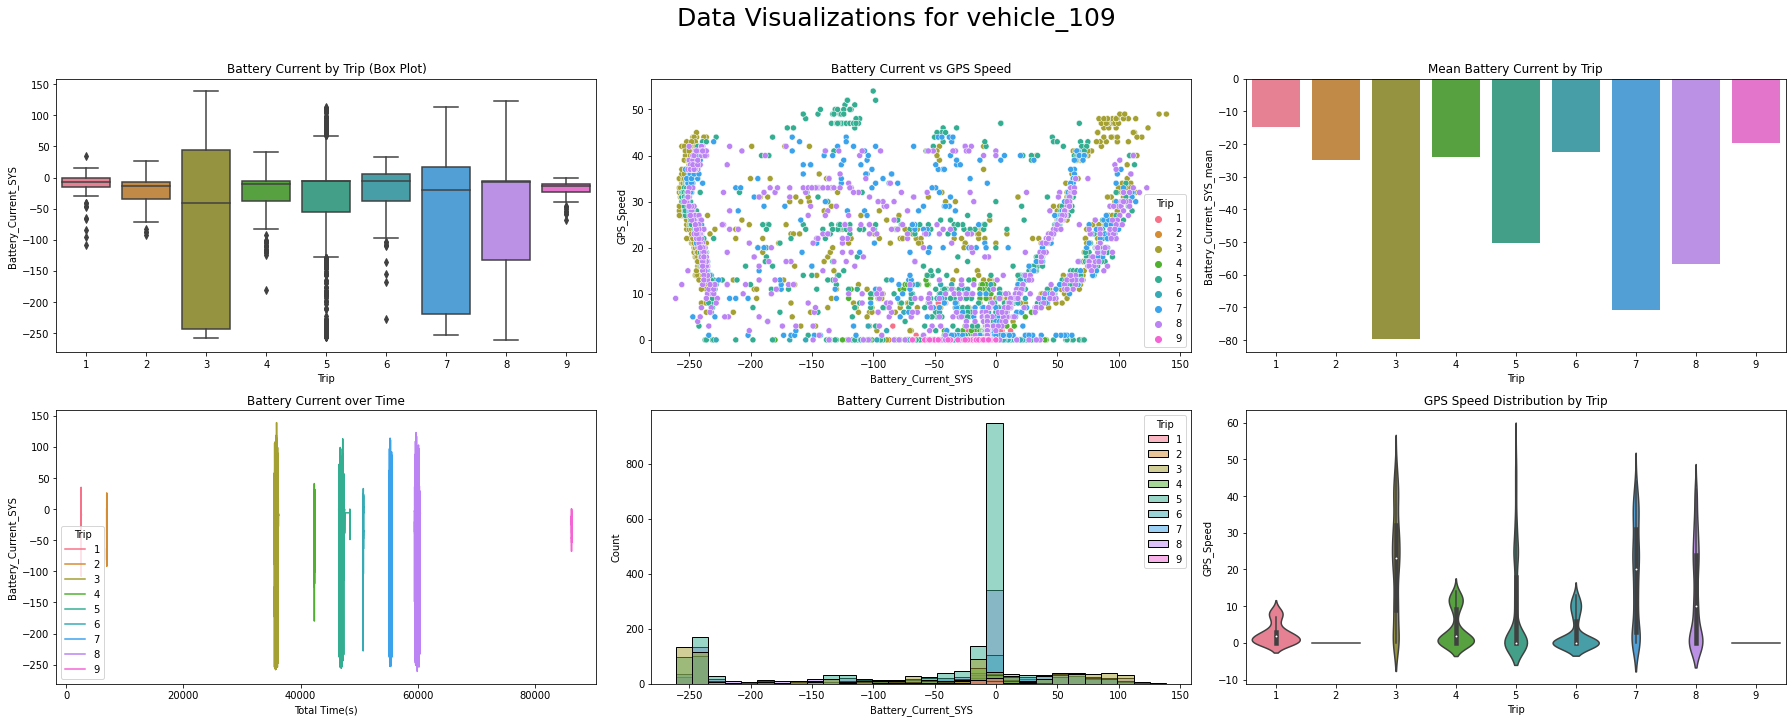

In [ ]:
# Create subplots for each plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
palette = sns.color_palette("husl", len(df_trip["Trip"].unique()))

# Histogram
sns.boxplot(data=df_trip, x="Trip", y="Battery_Current_SYS", palette=palette, ax=axes[0,0])
axes[0,0].set_title("Battery Current by Trip (Box Plot)")

# Scatter plot
sns.scatterplot(data=df_trip, x="Battery_Current_SYS", y="GPS_Speed", hue="Trip", palette=palette, ax=axes[0,1])
axes[0,1].set_title("Battery Current vs GPS Speed")

# Bar plot
sns.barplot(data=df_statistics, x="Trip", y="Battery_Current_SYS_mean", palette=palette, ax=axes[0,2])
axes[0,2].set_title("Mean Battery Current by Trip")

# Additional plot 1
sns.lineplot(data=df_trip, x="Total Time(s)", y="Battery_Current_SYS", hue="Trip", palette=palette, ax=axes[1,0])
axes[1,0].set_title("Battery Current over Time")

# Additional plot 2
sns.histplot(data=df_trip, x="Battery_Current_SYS", hue="Trip", palette=palette, ax=axes[1,1])
axes[1,1].set_title("Battery Current Distribution")

# Additional plot 3
sns.violinplot(data=df_trip, x="Trip", y="GPS_Speed", palette=palette, ax=axes[1,2])
axes[1,2].set_title("GPS Speed Distribution by Trip")

# Add overall title
plt.suptitle("Data Visualizations for " + path_prefix[path_prefix.rfind("/")+1:], fontsize = 25, y= 1)

# Adjust layout and show
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## 0.5. Merge multiple truck data files

In [ ]:
path_prefix = "/content/drive/MyDrive/ENS 491   F22/Data/Smith_Gen2 Vehicles Data"

In [ ]:
cols_to_keep = ['BMU_Mode_SYS','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS','Timestamp','RD_Ambient_Temp_degC']

In [ ]:
df_list = [] # Initialize an empty list to store dataframes
SEARCH_FILE_COUNT = 2
counter = 0

# Iterate over the directories and files in the path_prefix
for path, currentDirectory, files in os.walk(path_prefix):
    # Iterate over the files in the current directory
    print("Reading", os.path.basename(path) + "... ", end="")

    for file in files:
        if file.endswith('.mat'):
            try:
                mat = loadmat(join(path, file))

            except IOError:
                print(f"\nError reading file: {join(path, file)}")
                continue
                
            mat = {k: v for k, v in mat.items() if k[0] != '_'}
            df_temp = pd.DataFrame({k: np.array(v).flatten() for k, v in mat.items()})

            #selecting columns to keep
            df_temp = df_temp[cols_to_keep]

            # Convert the 'Timestamp' column to datetime
            df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'], unit='s')

            # Seconds[n] = Timestamp[n+1] - Timestamp[n]
            df_temp['Seconds difference'] = df_temp['Timestamp'].diff().dt.total_seconds()

            # Calculate the cumulative sum of the time differences
            df_temp['Total Time(s)'] = df_temp['Seconds difference'].cumsum()
            df_temp.at[0, "Total Time(s)"] = 0

            #DROPPING ANORMALIES
            df_temp = df_temp[(df_temp['GPS_Speed'] <= 50) & (df_temp['Battery_Voltage_SYS'] <= 346)]
            # df_temp = df_temp[df_temp['Battery_Voltage_SYS'] <= 346]

            #calculate power
            df_temp['Power(w)'] = df_temp['Battery_Voltage_SYS'] * df_temp['Battery_Current_SYS'] * -1

            # Select BMU
            df_temp = df_temp[df_temp['BMU_Mode_SYS'] == 2.0]

            # Partition the data to trips by using Total Time(s)
            # Assign trip numbers based on the difference in 'Total Time(s)'
            df_temp['Trip_diff'] = df_temp["Total Time(s)"].diff()
            df_temp["Trip"] = (df_temp['Trip_diff'] > 1000).cumsum() + 1

            # Drop the 'Trip_diff' column
            df_temp = df_temp.drop(['Trip_diff'], axis=1)

            # Create the vehicle_name extracting from path 
            # Insert the 'ID' and 'File_Name' columns 
            df_temp["ID"] = os.path.basename(path) + '_' + file[file.rfind("_")+1:file.rfind(".")] + "_trip_" + df_temp["Trip"].astype(str)
            df_temp["File_Name"] = file

            # Append the dataframe to the list
            df_list.append(df_temp)
    print(u'\u2713')

    if counter >= SEARCH_FILE_COUNT:
        break
    counter += 1

# Merge all dataframes in the list
print("Merging the files... ")
df_merged = pd.concat(df_list)
print("Files have been merged", u'\u2713')

Reading Smith_Gen2 Vehicles Data... ✓
Reading vehicle_109... ✓
Reading vehicle_173... ✓
Merging the files... 
Files have been merged ✓


In [ ]:
# Get a list of column names
column_names = df_merged.columns.tolist()

# Move 'File' and 'ID' columns to the front of the list
column_names.insert(0, column_names.pop(column_names.index('File_Name')))
column_names.insert(1, column_names.pop(column_names.index('ID')))

# Reorder the DataFrame columns using the updated list
df_merged = df_merged[column_names]


,File_Name,ID,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,Trip,Power(w),Total Time(s)
0,device_06D_2013-01-10.mat,vehicle_109_trip_1,2.0,NaN,346.0,-5.0,2013-01-10 23:36:19,NaN,1,1730.0,0.0
1,device_06D_2013-01-10.mat,vehicle_109_trip_1,2.0,NaN,346.0,-7.0,2013-01-10 23:36:20,NaN,1,2422.0,1.0
2,device_06D_2013-01-10.mat,vehicle_109_trip_1,2.0,NaN,346.0,-9.0,2013-01-10 23:36:21,NaN,1,3114.0,2.0
3,device_06D_2013-01-10.mat,vehicle_109_trip_1,2.0,NaN,346.0,-10.0,2013-01-10 23:36:22,NaN,1,3460.0,3.0
4,device_06D_2013-01-10.mat,vehicle_109_trip_1,2.0,NaN,346.0,-10.0,2013-01-10 23:36:23,NaN,1,3460.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
1550,device_0AD_2014-04-15.mat,vehicle_173_trip_1,2.0,0.0,344.0,0.0,2014-04-15 22:17:13,NaN,1,-0.0,1550.0
1551,device_0AD_2014-04-15.mat,vehicle_173_trip_1,2.0,0.0,344.0,0.0,2014-04-15 22:17:14,NaN,1,-0.0,1551.0
1552,device_0AD_2014-04-15.mat,vehicle_173_trip_1,2.0,0.0,344.0,0.0,2014-04-15 22:17:15,NaN,1,-0.0,1552.0
1553,device_0AD_2014-04-15.mat,vehicle_173_trip_1,2.0,0.0,344.0,0.0,2014-04-15 22:17:16,NaN,1,-0.0,1553.0


## 0.6 Calculation of energy consumption for all files of a truck

In [5]:
path_prefix = "../Smith_Gen2 Vehicles Data/vehicle_109"
count = 0
PRINT_COUNTER = 5

for filename in os.listdir(path_prefix):
    with open(os.path.join(path_prefix, filename), 'r') as f: 

        mat = loadmat(join(path_prefix, filename))
        mat = {k:v for k, v in mat.items() if k[0] != '_'}
        df = pd.DataFrame({k: np.array(v).flatten() for k, v in mat.items()})

        # Seconds[n] = Timestamp[n+1] - Timestamp[n]
        df['Seconds difference'] = df['Timestamp'].diff()

        df['Total Time(s)'] = df['Seconds difference'].cumsum()
        df.at[0, "Total Time(s)"] = 0
              
        df['Power(w)'] = df['Battery_Voltage_SYS'] * df['Battery_Current_SYS'] * -1
        df = df[df['BMU_Mode_SYS'] == 2.0]

        energy_consumption = np.trapz(y=df["Power(w)"], x=df["Total Time(s)"])
        
        # Convert energy consumption from watt-hours to kilowatt-hours
        energy_consumption_kwh = energy_consumption / 3600000

        if count < PRINT_COUNTER:
            print(f"{filename}: energy consumption is {energy_consumption_kwh} kWh")
            count+=1
        else:
            break


device_06D_2013-01-09.mat: energy consumption is 0.17636388888888888 kWh
device_06D_2013-01-10.mat: energy consumption is 0.07117027777777778 kWh
device_06D_2013-01-11.mat: energy consumption is 0.2126625 kWh
device_06D_2013-01-12.mat: energy consumption is 59.80950194444444 kWh
device_06D_2013-01-13.mat: energy consumption is 0.06328222222222223 kWh
